In [24]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

# This will help in making the Python code more structured automatically (good coding practice)
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

Description
Background & Context

The Thera bank recently saw a steep decline in the number of users of their credit card, credit cards are a good source of income for banks because of different kinds of fees charged by the banks like annual fees, balance transfer fees, and cash advance fees, late payment fees, foreign transaction fees, and others. Some fees are charged to every user irrespective of usage, while others are charged under specified circumstances.

Customers’ leaving credit cards services would lead bank to loss, so the bank wants to analyze the data of customers and identify the customers who will leave their credit card services and reason for same – so that bank could improve upon those areas

You as a Data scientist at Thera bank need to come up with a classification model that will help the bank improve its services so that customers do not renounce their credit cards

You need to identify the best possible model that will give the required performance

Objective

Explore and visualize the dataset.
Build a classification model to predict if the customer is going to churn or not
Optimize the model using appropriate techniques
Generate a set of insights and recommendations that will help the bank
Data Dictionary:

CLIENTNUM: Client number. Unique identifier for the customer holding the account
Attrition_Flag: Internal event (customer activity) variable - if the account is closed then "Attrited Customer" else "Existing Customer"
Customer_Age: Age in Years
Gender: Gender of the account holder
Dependent_count: Number of dependents
Education_Level:  Educational Qualification of the account holder - Graduate, High School, Unknown, Uneducated, College(refers to a college student), Post-Graduate, Doctorate.
Marital_Status: Marital Status of the account holder
Income_Category: Annual Income Category of the account holder
Card_Category: Type of Card
Months_on_book: Period of relationship with the bank
Total_Relationship_Count: Total no. of products held by the customer
Months_Inactive_12_mon: No. of months inactive in the last 12 months
Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months
Credit_Limit: Credit Limit on the Credit Card
Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
Avg_Open_To_Buy: Open to Buy refers to the amount left on the credit card to use (Average of last 12 months)
Total_Trans_Amt: Total Transaction Amount (Last 12 months)
Total_Trans_Ct: Total Transaction Count (Last 12 months)
Total_Ct_Chng_Q4_Q1: Ratio of the total transaction count in 4th quarter and the total transaction count in 1st quarter
Total_Amt_Chng_Q4_Q1: Ratio of the total transaction amount in 4th quarter and the total transaction amount in 1st quarter
Avg_Utilization_Ratio: Represents how much of the available credit the customer spent


In [25]:
df = pd.read_csv('BankChurners.csv')

<IPython.core.display.Javascript object>

In [26]:
df.shape

(10127, 21)

<IPython.core.display.Javascript object>

In [27]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,NaN,Less than $40K,Blue,34,3,4,1,3313.000,2517,796.000,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000


<IPython.core.display.Javascript object>

* Dependant Variable = Attrition_Flag
* It looks like the Income_Category attribute has some data 'abc' that does not fit will look at it furthere down
* Can drop clientnum as it wont be relevant to build this model but will be in use of the model later. 
* Generate One Hots
    - Attrition_Flag
    - Gender
    - Education_Level
    - Married_Status
    - Income_Category
    - Card_Category

In [32]:
df = df.drop(columns='CLIENTNUM')
one_hots = ['Attrition_Flag','Gender','Education_Level','Marital_Status','Income_Category', 'Card_Category']

<IPython.core.display.Javascript object>

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           8608 non-null   object 
 5   Marital_Status            9378 non-null   object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

<IPython.core.display.Javascript object>

In [35]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,10127.000,46.326,8.017,26.000,41.000,46.000,52.000,73.000
Dependent_count,10127.000,2.346,1.299,0.000,1.000,2.000,3.000,5.000
Months_on_book,10127.000,35.928,7.986,13.000,31.000,36.000,40.000,56.000
Total_Relationship_Count,10127.000,3.813,1.554,1.000,3.000,4.000,5.000,6.000
Months_Inactive_12_mon,10127.000,2.341,1.011,0.000,2.000,2.000,3.000,6.000
Contacts_Count_12_mon,10127.000,2.455,1.106,0.000,2.000,2.000,3.000,6.000
Credit_Limit,10127.000,8631.954,9088.777,1438.300,2555.000,4549.000,11067.500,34516.000
Total_Revolving_Bal,10127.000,1162.814,814.987,0.000,359.000,1276.000,1784.000,2517.000
Avg_Open_To_Buy,10127.000,7469.140,9090.685,3.000,1324.500,3474.000,9859.000,34516.000
Total_Amt_Chng_Q4_Q1,10127.000,0.760,0.219,0.000,0.631,0.736,0.859,3.397


<IPython.core.display.Javascript object>

In [36]:
# Generating a data frame of missing values by count and %
missing = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing = pd.DataFrame(missing, columns=['%'])
missing['count'] = df.isnull().sum()

<IPython.core.display.Javascript object>

In [37]:
print('Missing Values in the data frame')
missing.head()

Missing Values in the data frame


,%,count
Education_Level,15.000,1519
Marital_Status,7.396,749
Attrition_Flag,0.000,0
Contacts_Count_12_mon,0.000,0
Total_Ct_Chng_Q4_Q1,0.000,0


<IPython.core.display.Javascript object>

There are a large number of missing values in:
     - Education_Level
     - Martial_Status

Will have to look into these attributues in addition to the Income_Category to see if we can impute the data or need to drop those rows

In [38]:
print('The count of unique values in the data frame')
df.nunique().sort_values(ascending=False)

The count of unique values in the data frame


Avg_Open_To_Buy             6813
Credit_Limit                6205
Total_Trans_Amt             5033
Total_Revolving_Bal         1974
Total_Amt_Chng_Q4_Q1        1158
Avg_Utilization_Ratio        964
Total_Ct_Chng_Q4_Q1          830
Total_Trans_Ct               126
Customer_Age                  45
Months_on_book                44
Contacts_Count_12_mon          7
Months_Inactive_12_mon         7
Total_Relationship_Count       6
Income_Category                6
Education_Level                6
Dependent_count                6
Card_Category                  4
Marital_Status                 3
Gender                         2
Attrition_Flag                 2
dtype: int64

<IPython.core.display.Javascript object>

In [39]:
# Printing a list of unique values, values shown in text file. Some categories have a large number of values so dropping those

vc = df.columns.drop(['Avg_Open_To_Buy','Credit_Limit','Total_Revolving_Bal','Total_Amt_Chng_Q4_Q1', 'Avg_Utilization_Ratio','Total_Ct_Chng_Q4_Q1','Total_Trans_Ct','Customer_Age','Months_on_book',])
for i in vc:
    print(i,'Has the following Unique Values')
    print(df[i].value_counts().sort_values(ascending=False))
    print('-'*50)

Attrition_Flag Has the following Unique Values
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
--------------------------------------------------
Gender Has the following Unique Values
F    5358
M    4769
Name: Gender, dtype: int64
--------------------------------------------------
Dependent_count Has the following Unique Values
3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64
--------------------------------------------------
Education_Level Has the following Unique Values
Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
--------------------------------------------------
Marital_Status Has the following Unique Values
Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64
--------------------------------------------------
Income_Category Has the followin

<IPython.core.display.Javascript object>

### Data Initial observations
* CLEINTNUM is not needed for this model we can use the index and drop this column
* Attrition_Flag is our dependant variable
<br/><br/>

* The following columns have missing values or other issues we will need to fix
   - Education_Level - has a number of missing values, will drop those as there is no hard data to fill in
   - Marital_Status - has a number of missing values, will drop those as there is no hard data to fill in
   - Income_Category - has a category 'abc', those rows might need to be dropped if no correlations can be found to impute the data. 
   <br/><br/>

* The following categorical columns can be dummies
   - Attrition_Flag
   - Gender
   - Education_Level
   - Married_Status
   - Income_Category
   - Card_Category
   <br/><br/>

* Customer Observation:
   -  Customers range in age from mid 20s to early 70s. The average customer age is mid 40s
   -  Customers have an average of 2.3 dependants
   -  On average customers have been with the bank for right at 3 years, with the longest being 56 months. This is a newer bank
   -  The min age for a customer is 13 months, this means the bank has not signed any new customers in over a year.
   - The typical customer has 3-4 products from the bank
   - Most inactive customers have been so for just over 2 months, it would appear inactive accounts are closed after 12 months
   - The bank attempts to contact a customer 2-3 times a year
   - The average credit limit 8600 with the max being 34,500
   - The typical customer carries over a roughly 1200 balance month to month  
   - Most customers use less than 25% of their available credit    
   <br/><br/>

* Attributes with Possible Outliers:
   - Credit_Limit - has a high end roughly 3 times that of the 75% quartile. While this is most likely an outlier I do not know it is bad for the model. Will dig more into this.
   - Avg_Utilization_Ratio - has a max almost double the 75%. That being said this might skew the model but is data that is important to identifying customer trends. 
   <br/><br/>

* General Observations:
   - The income category has a value of ‘abc’ that will need treatment
   <br/><br/>


### Fixing Education_Level, Marital_Status & Income_Categories  

- Dropping missing values  
- Evaluating if there is a way to impute Income_Categories from the data available

In [40]:
# Dropping rows with missing values
df.dropna(inplace=True)

# Confirming all missing values have been treated
df.isnull().sum().sort_index(ascending=True)

Attrition_Flag              0
Avg_Open_To_Buy             0
Avg_Utilization_Ratio       0
Card_Category               0
Contacts_Count_12_mon       0
Credit_Limit                0
Customer_Age                0
Dependent_count             0
Education_Level             0
Gender                      0
Income_Category             0
Marital_Status              0
Months_Inactive_12_mon      0
Months_on_book              0
Total_Amt_Chng_Q4_Q1        0
Total_Ct_Chng_Q4_Q1         0
Total_Relationship_Count    0
Total_Revolving_Bal         0
Total_Trans_Amt             0
Total_Trans_Ct              0
dtype: int64

<IPython.core.display.Javascript object>

In [41]:
# Lets look at Income Category
df['Income_Category'].value_counts().sort_values(ascending=True)

$120K +            572
abc                892
$60K - $80K       1103
$80K - $120K      1202
$40K - $60K       1412
Less than $40K    2792
Name: Income_Category, dtype: int64

<IPython.core.display.Javascript object>

In [44]:
# Creating a dataframe for rows with 'abc' for Income_Category to look at the data
abc = df.loc[df['Income_Category'] == 'abc']
abc.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
19,Existing Customer,45,F,2,Graduate,Married,abc,Blue,37,6,1,2,14470.000,1157,13313.000,0.966,1207,21,0.909,0.080
28,Existing Customer,44,F,3,Uneducated,Single,abc,Blue,34,5,2,2,10100.000,0,10100.000,0.525,1052,18,1.571,0.000
39,Attrited Customer,66,F,0,Doctorate,Married,abc,Blue,56,5,4,3,7882.000,605,7277.000,1.052,704,16,0.143,0.077
44,Existing Customer,38,F,4,Graduate,Single,abc,Blue,28,2,3,3,9830.000,2055,7775.000,0.977,1042,23,0.917,0.209
58,Existing Customer,44,F,5,Graduate,Married,abc,Blue,35,4,1,2,6273.000,978,5295.000,2.275,1359,25,1.083,0.156


<IPython.core.display.Javascript object>

There is not a good correlation to impute a usable value instead of 'abc' will drop all rows with that value.

In [49]:
df = df[df['Income_Category'] != 'abc']
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.000,777,11914.000,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.000,864,7392.000,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.000,0,3418.000,2.594,1887,20,2.333,0.000
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.000,0,4716.000,2.175,816,28,2.500,0.000
5,Existing Customer,44,M,2,Graduate,Married,$40K - $60K,Blue,36,3,1,2,4010.000,1247,2763.000,1.376,1088,24,0.846,0.311


<IPython.core.display.Javascript object>

In [50]:
df.shape

(7081, 20)

<IPython.core.display.Javascript object>

Between missing value treatments and the bad data for income we have cut out about 30% of our data set. 

## EDA  
-------------------------------
#### Reusable Functions
- Reusing functions provided in the class  
- Functions for both Univariate and Bivariate Analysis

In [51]:
# reusing provided function for generating graphs

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [52]:
# reusing provided function for generating graphs
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

In [53]:
# reusing provided function for generating graphs

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart
    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

<IPython.core.display.Javascript object>

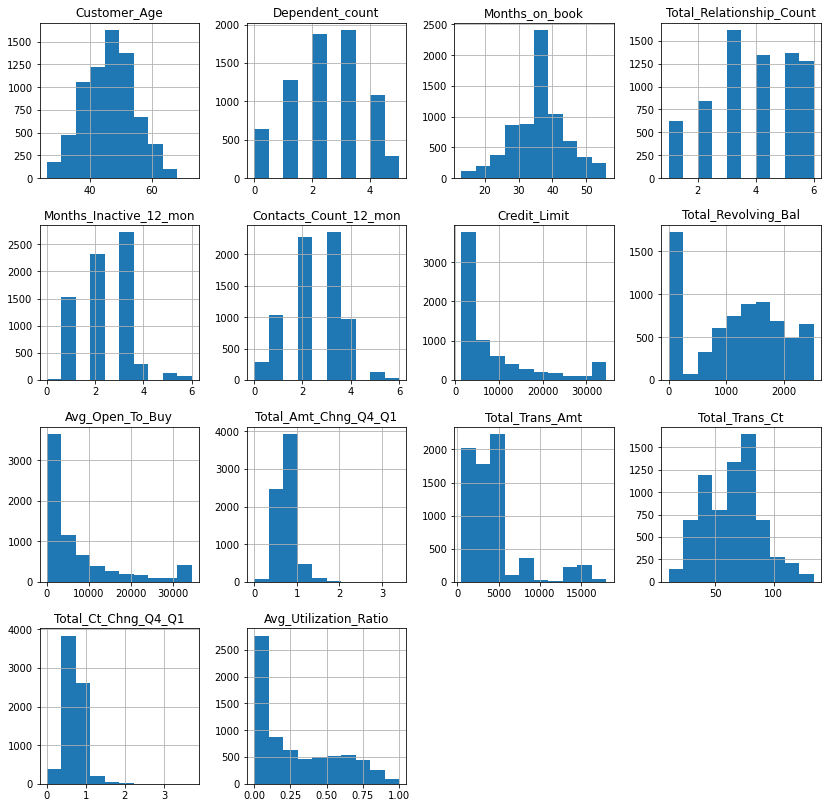

<IPython.core.display.Javascript object>

In [54]:
# creating histograms
df.hist(figsize=(14, 14))
plt.show()

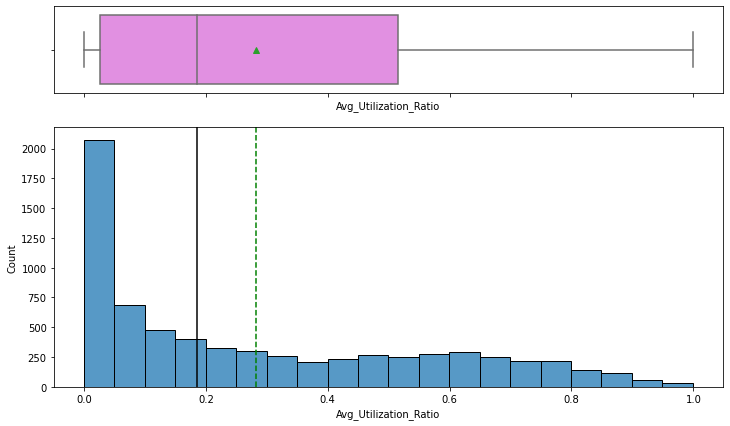

<IPython.core.display.Javascript object>

In [55]:
histogram_boxplot(df, 'Avg_Utilization_Ratio')

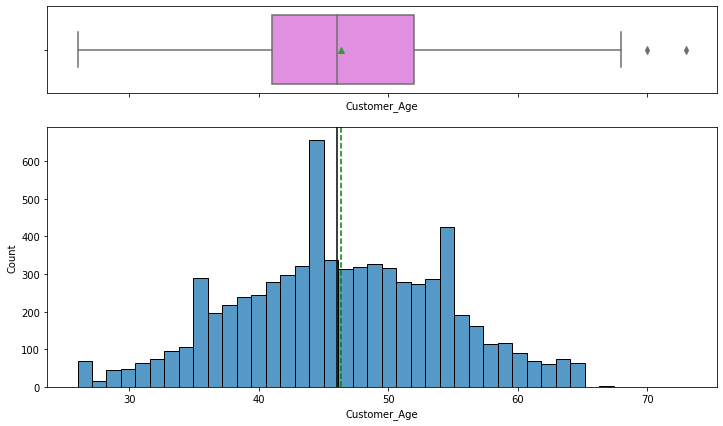

<IPython.core.display.Javascript object>

In [57]:
histogram_boxplot(df, 'Customer_Age')